# Data Pipeline

This notebook describes the pipeline for milestone 3 for our project. It should give an overview of how we intend to load, clean, parse and exploit our data for our story telling.

In [1]:
#Load data
%run ./load_data.ipynb

c:\Users\augus\miniconda3\envs\ada\lib\site-packages\nbformat\__init__.py:93: MissingIDFieldWarning: Code cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


## Imports

In [2]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.cluster.hierarchy import linkage,dendrogram,fcluster
from collections import defaultdict

# Genres analysis

We want to focus on genres, to see how Hollywood can be creative through those. Our leading cues will be :
- How do genres appear ?
- How do they correlate ? 
- When do they emerge ?
- Do they follow a trend ?


To work on genres, we will alter the dataframe so as not to have genres in sublist. We will create one entry per genre for a movie :

In [3]:
movie_genre = []
for index, row in movie[["Movie_name", "Movie_genres"]].dropna().iterrows():
    sublist = row["Movie_genres"]
    for genre in sublist:
        movie_genre.append((row["Movie_name"], genre))
movie_genre = pd.DataFrame(movie_genre, columns=["name", "genre"])

In [4]:
movie_genre.describe()

,name,genre
count,243329,243329
unique,73373,363
top,The Three Musketeers,Drama
freq,62,34007


363 genres are too many. Let's see if we can regroup them !

To evaluate the performance of the regrouping, a new metric will be set : see how well they describe the dataset, i.e. how many movies are left behind with these new classifications.


In [5]:
def evaluate_regrouping(old_df, new_df):
    return len(new_df.name.unique()) / len(old_df.name.unique())

In [6]:
# test
evaluate_regrouping(movie_genre, movie_genre)

1.0

## Naive approach : Removing the less present ones


A first hint could be to see how often they appear in movies

In [7]:
count_genres = (
    movie_genre.groupby(by="genre").agg("count").sort_values(by="name", ascending=False)
)
print(count_genres)

                   name
genre                  
Drama             34007
Comedy            16349
Romance Film      10234
Black-and-white    9094
Action             8798
...                 ...
Comdedy               1
New Queer Cinema      1
Linguistics           1
Statutory rape        1
C-Movie               1

[363 rows x 1 columns]


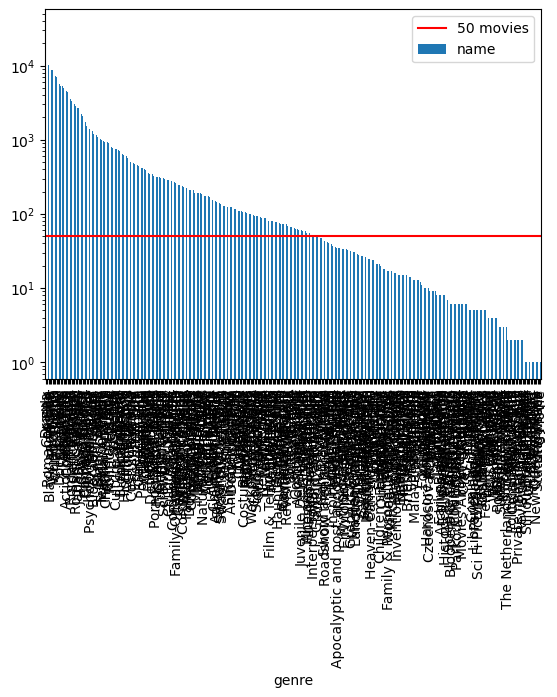

In [8]:
count_genres.plot(kind="bar")
plt.yscale("log")
plt.axhline(y=50, color="r", linestyle="-", label="50 movies")
plt.legend()

We notice that a lot of those genres only concern a very few movies (about half are identified in less than 50 movies). It has been decided to keep only the most relevant ones, i.e. those who appear at least in 1% of movies

53 genres appear in at least 1% of all movies, i.e. in 733 movies.
Those genres are : ['Drama', 'Comedy', 'Romance Film', 'Black-and-white', 'Action', 'Thriller', 'Short Film', 'World cinema', 'Crime Fiction', 'Indie', 'Documentary', 'Horror', 'Silent film', 'Adventure', 'Family Film', 'Action/Adventure', 'Comedy film', 'Musical', 'Animation', 'Romantic drama', 'Mystery', 'Science Fiction', 'Fantasy', 'Romantic comedy', 'War film', 'Japanese Movies', 'Western', 'Crime Thriller', 'Period piece', 'Comedy-drama', 'Film adaptation', 'Chinese Movies', 'Biography', 'Psychological thriller', 'Bollywood', 'Sports', 'Biographical film', 'LGBT', 'Music', 'Family Drama', 'Black comedy', 'Parody', 'Television movie', 'Martial Arts Film', "Children's/Family", 'Teen', 'Coming of age', 'History', 'Political drama', 'Slasher', 'Suspense', 'Cult', 'Culture & Society']


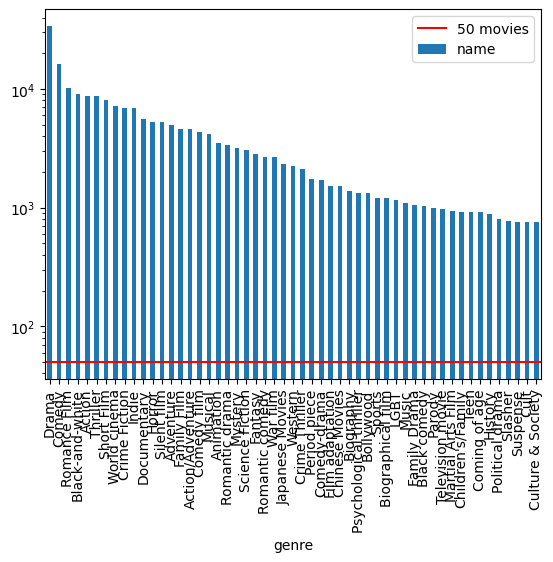

In [9]:
n_movies = len(movie_genre.name.unique())
n = (count_genres.name > 0.01 * n_movies).sum()
print(
    "%i genres appear in at least 1%% of all movies, i.e. in %i movies."
    % (n, int(0.01 * n_movies))
)
print(
    "Those genres are : %s"
    % list(count_genres[count_genres.name > 0.01 * n_movies].index)
)


count_genres[count_genres.name > 0.01 * n_movies].plot(kind="bar")
plt.yscale("log")
plt.axhline(y=50, color="r", linestyle="-", label="50 movies")
plt.legend()

In [10]:
print(count_genres[count_genres.name > 0.01 * n_movies].index)

Index(['Drama', 'Comedy', 'Romance Film', 'Black-and-white', 'Action',
       'Thriller', 'Short Film', 'World cinema', 'Crime Fiction', 'Indie',
       'Documentary', 'Horror', 'Silent film', 'Adventure', 'Family Film',
       'Action/Adventure', 'Comedy film', 'Musical', 'Animation',
       'Romantic drama', 'Mystery', 'Science Fiction', 'Fantasy',
       'Romantic comedy', 'War film', 'Japanese Movies', 'Western',
       'Crime Thriller', 'Period piece', 'Comedy-drama', 'Film adaptation',
       'Chinese Movies', 'Biography', 'Psychological thriller', 'Bollywood',
       'Sports', 'Biographical film', 'LGBT', 'Music', 'Family Drama',
       'Black comedy', 'Parody', 'Television movie', 'Martial Arts Film',
       'Children's/Family', 'Teen', 'Coming of age', 'History',
       'Political drama', 'Slasher', 'Suspense', 'Cult', 'Culture & Society'],
      dtype='object', name='genre')


In [11]:
naive_selection = movie_genre.genre.isin(
    count_genres[count_genres.name > 0.01 * n_movies].index
)
naive_filtering = movie_genre[naive_selection]

evaluate_regrouping(movie_genre, naive_filtering)

0.9868616521063607

But a thorough investigation on the genres left after the filtering shows us a few genres seem to be the same while having different names.

For instance, we could regroup the `Family` with the `Children's/Family` genre.
Or we could regroup `Biography` and `Biographical Film`.

How could we do so ?

## Clustering the genres

A first approach could be to cluster them using similarities between the other genres they are paired with.

In [12]:
genres = movie_genre.genre.unique()
mapping_dict = dict()
for i in range(len(genres)):
    mapping_dict[genres[i]] = i

co_occurrence_matrix = np.zeros((len(genres), len(genres)))
for idnex, row in movie[["Movie_genres"]].dropna().iterrows():
    genres_of_movie = row["Movie_genres"]
    for i1 in range(len(genres_of_movie)):
        for i2 in range(i1 + 1, len(genres_of_movie)):
            co_occurrence_matrix[
                mapping_dict[genres_of_movie[i1]], mapping_dict[genres_of_movie[i2]]
            ] += 1
            co_occurrence_matrix[
                mapping_dict[genres_of_movie[i2]], mapping_dict[genres_of_movie[i1]]
            ] += 1

In [13]:
# Why though ?
for i in range(len(genres)):
    for j in range(i + 1, len(genres)):
        co_occurrence_matrix[i, j] /= min(count_genres.name[i], count_genres.name[j])
        co_occurrence_matrix[j, i] = co_occurrence_matrix[i, j]

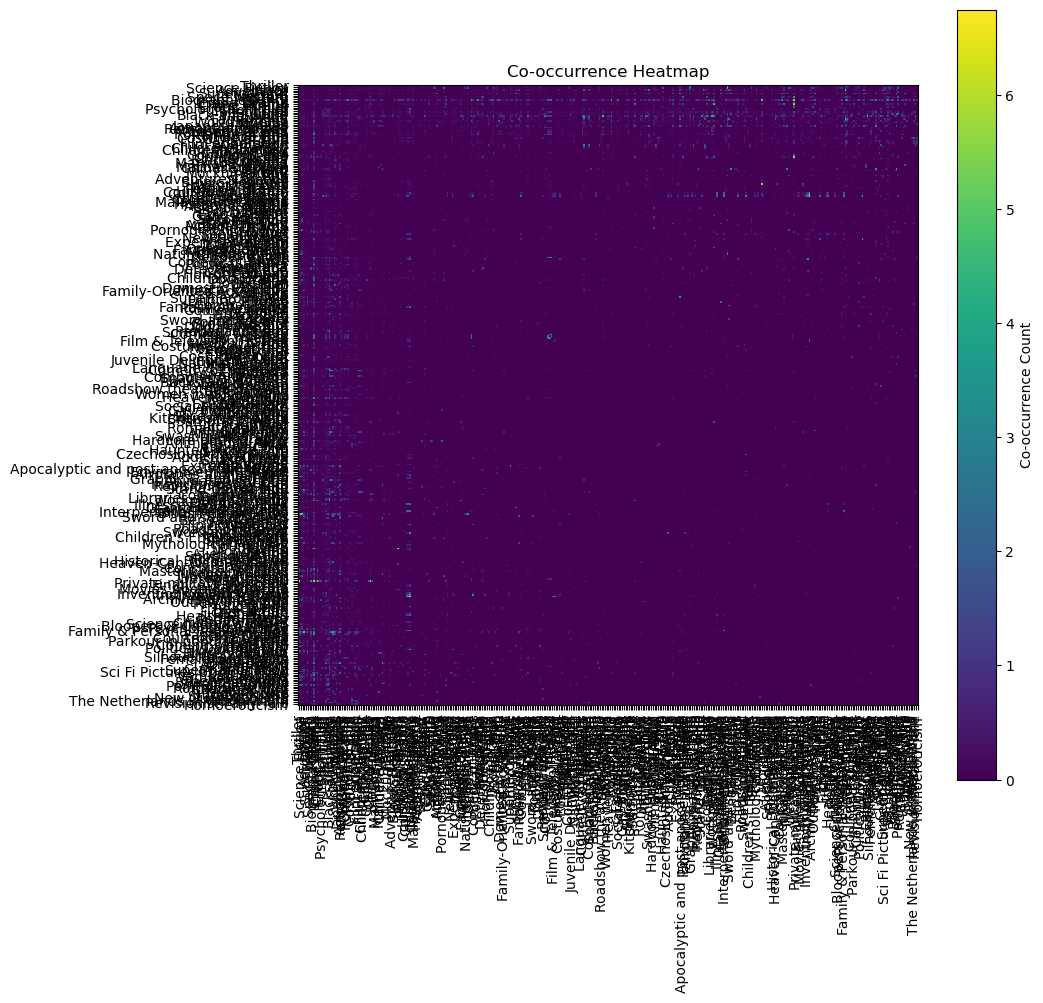

In [14]:
co_occurrence_matrix = np.clip(co_occurrence_matrix, 0, 1000)
plt.figure(figsize=(10, 10))
plt.imshow(co_occurrence_matrix, cmap="viridis", interpolation="none")
plt.colorbar(label="Co-occurrence Count")
plt.xticks(
    np.arange(len(genres)),
    genres,
    rotation=90,
)
plt.yticks(np.arange(len(genres)), genres)
plt.title("Co-occurrence Heatmap")
plt.show()


A naive approach would be to direct do a clustering as below.

Drama                   34007.0
Comedy                  16349.0
Romance Film            10234.0
Black-and-white          9094.0
Action                   8798.0
                         ...   
Romantic thriller           1.0
Comdedy                     1.0
C-Movie                     1.0
Silhouette animation        1.0
Homoeroticism               1.0
Length: 363, dtype: float64


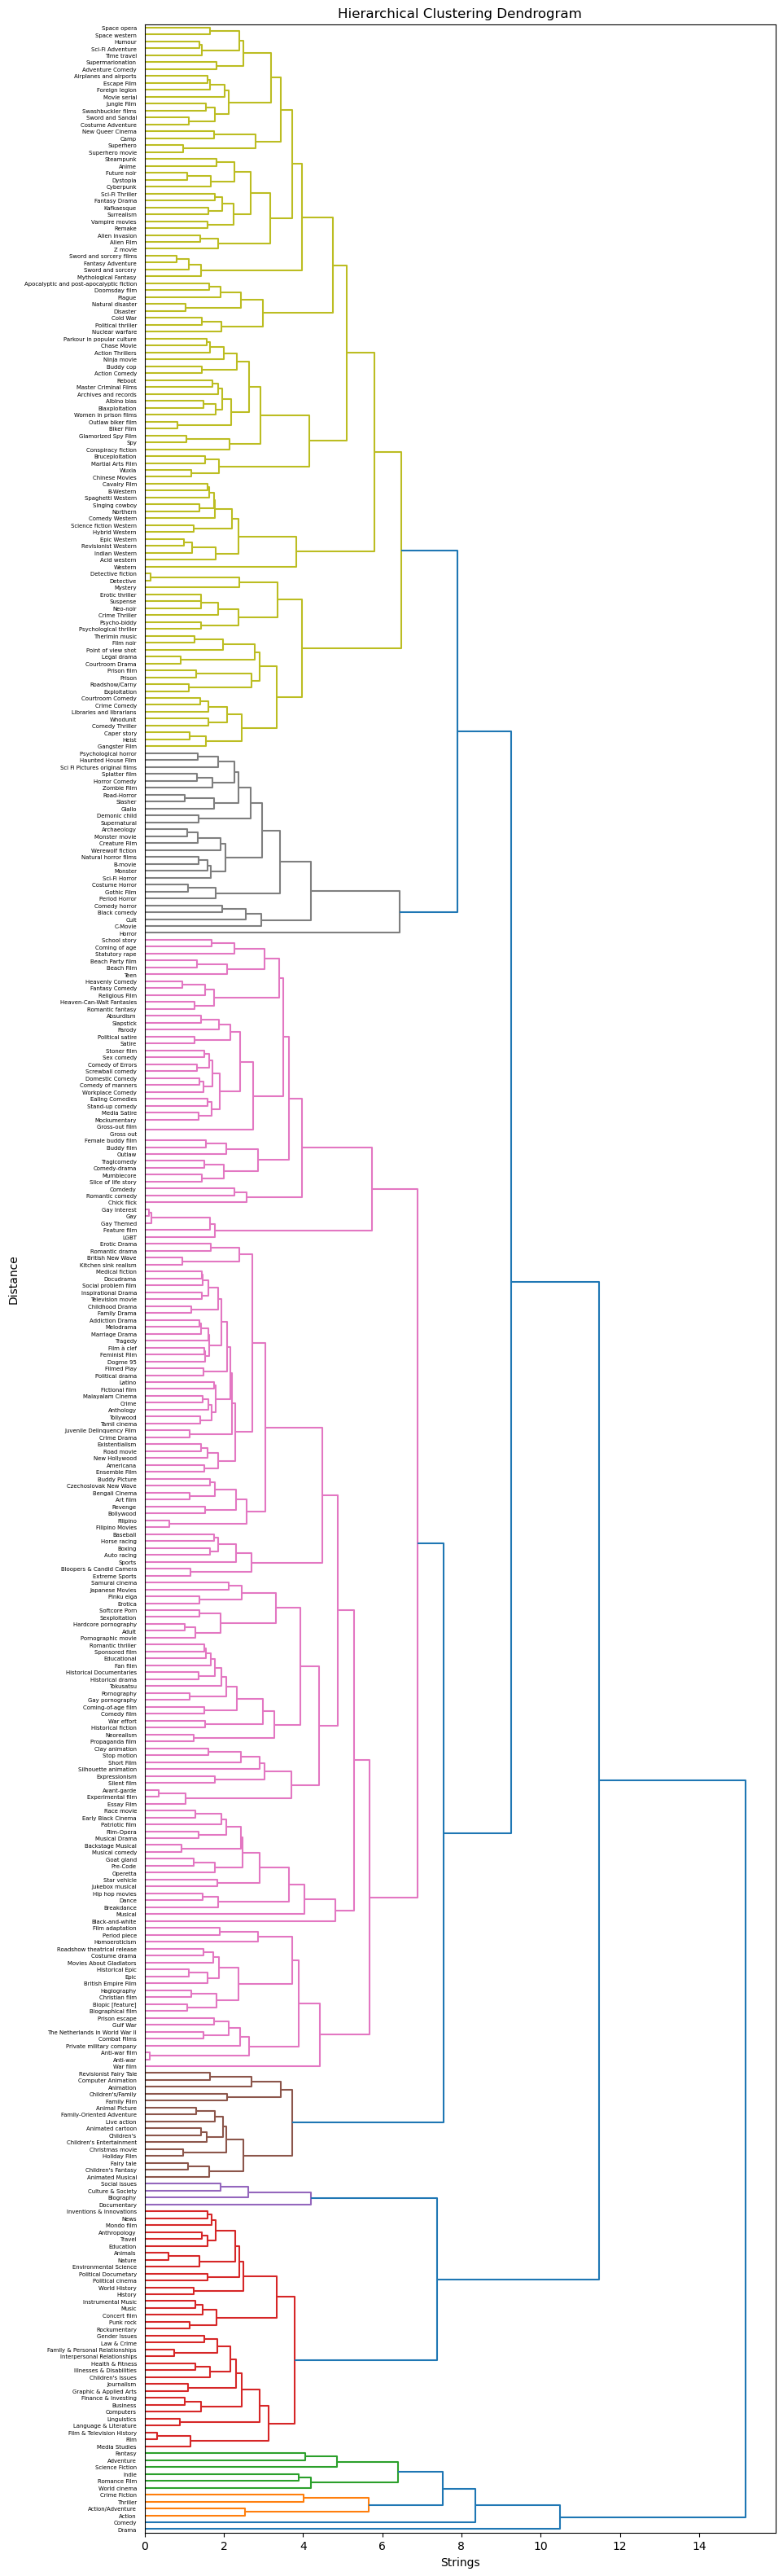

In [15]:
total_occurences_naive = (
    movie["Movie_genres"]
    .apply(lambda x: pd.Series(x).value_counts())
    .sum()
    .sort_values(ascending=False)
)
print(total_occurences_naive)
co_occurrence_matrix_naive = pd.DataFrame(
    0, columns=total_occurences_naive.index, index=total_occurences_naive.index
)



# Fill in the co-occurrence matrix



for sublist in movie["Movie_genres"].dropna():
    for i in range(len(sublist)):
        co_occurrence_matrix_naive.at[sublist[i], sublist[i]] += 1

        for j in range(i + 1, len(sublist)):
            string1, string2 = sublist[i], sublist[j]

            co_occurrence_matrix_naive.at[string1, string2] += 1

            co_occurrence_matrix_naive.at[string2, string1] += 1



for i in total_occurences_naive.index:
    for j in total_occurences_naive.index:

        co_occurrence_matrix_naive.at[i, j] = co_occurrence_matrix_naive.at[i, j] / min(
            total_occurences_naive[i], total_occurences_naive[j]
        )



linkage_matrix_naive = linkage(co_occurrence_matrix_naive, method="ward")
plt.figure(figsize=(10, 40))


dendrogram(
    linkage_matrix_naive,
    labels=co_occurrence_matrix_naive.index,
    orientation="right",
    color_threshold=7,
)


plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Strings")
plt.ylabel("Distance")
plt.show()

We clearly see that this clustering is not doing a good job, for exemple for the comedy movies where different kind of comedies are not gathered together.

## Manual assignment of genres

### Genres cleaning

We filter the genres by not taking into account the genres with less than 500 movies (1) and by gathering the other into 30 custom main genres thanks to the `clean_genres` function and `categorized_genres` mapping dictionnary available in the `src/genres_analysis.py` file. 

NB: This mapping dictionnary has been set such that one initial genres may split in two custom main genres, for exemple "Romantic Comedy" will appear in "Romance" and "Comedy"

(1) As shown below, omit these genres does not really affect the number of movies withe genre(s) (at least one)

In [16]:
from src.genres_analysis import clean_genres, CATEGORIZED_GENRES
from src.genres_analysis import OLD_TO_NEW_GENRES

movie["Movie_clean_genres"] = (
    movie["Movie_genres"].dropna().apply(lambda x: clean_genres(x, CATEGORIZED_GENRES))
)

To create reverse mapping :

In [17]:
# mapping = dict()
# reverse_mapping = dict(CATEGORIZED_GENRES)
# print(reverse_mapping['Drama'])
# for genre in movie_genre.genre.unique():
#     mapping[genre] = []
#     for key in reverse_mapping:
#         if genre in reverse_mapping[key]:
#             mapping[genre].append(key)
#     if len(mapping[genre]) == 0 :
#         mapping.pop(genre)

# print(mapping)
# print()

In [18]:
def replace_genre(genre):
    try:
        return OLD_TO_NEW_GENRES[genre]
    except:
        return float("NaN")

In [19]:
movie_genre_replaced = movie_genre.copy()
movie_genre_replaced["genre"] = (
    movie_genre_replaced.genre.dropna().apply(lambda x: replace_genre(x)).dropna()
)
movie_genre_replaced.describe()

,name,genre
count,243329,212659
unique,73373,33
top,The Three Musketeers,[Drama]
freq,62,36575


In [20]:
print(
    "Only %.2f %% of movies are ignored after removing genres with less than 500 movies"
    % (
        1
        - len(movie["Movie_clean_genres"].dropna())
        / len(movie["Movie_genres"].dropna())
    )
)

Only 0.01 % of movies are ignored after removing genres with less than 500 movies


*Should add a visualisation for how many films are changed*

The number of film with clean genres is not significantly lower than the number of film with initial genres. Therefore the `categorized_genres` mapping dictionnary did great.

### Genres clustering

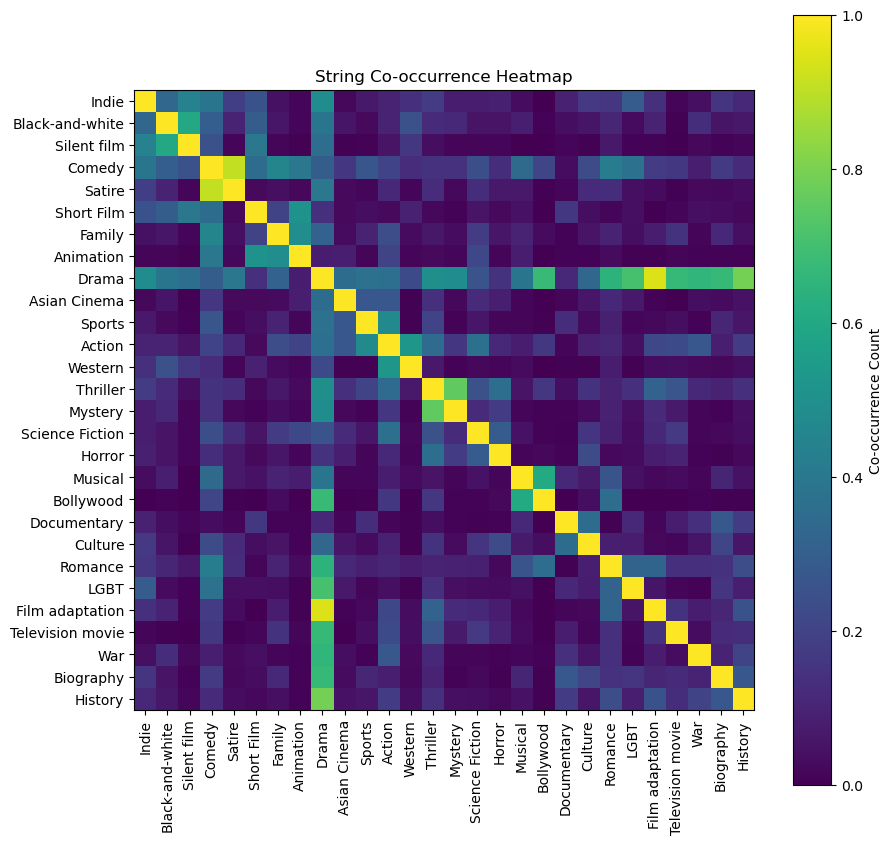

In [21]:
total_occurences = (
    movie["Movie_clean_genres"]
    .apply(lambda x: pd.Series(x).value_counts())
    .sum()
    .sort_values(ascending=False)
)
co_occurrence_matrix = pd.DataFrame(
    0, columns=total_occurences.index, index=total_occurences.index
)



# Fill in the co-occurrence matrix


for sublist in movie["Movie_clean_genres"].dropna():
    for i in range(len(sublist)):

        co_occurrence_matrix.at[sublist[i], sublist[i]] += 1

        for j in range(i + 1, len(sublist)):

            string1, string2 = sublist[i], sublist[j]

            co_occurrence_matrix.at[string1, string2] += 1

            co_occurrence_matrix.at[string2, string1] += 1



for i in total_occurences.index:
    for j in total_occurences.index:

        co_occurrence_matrix.at[i, j] = co_occurrence_matrix.at[i, j] / min(
            total_occurences[i], total_occurences[j]
        )



linkage_matrix = linkage(co_occurrence_matrix, method="ward")


co_occurrence_matrix_sorted = co_occurrence_matrix.loc[
    co_occurrence_matrix.index[
        dendrogram(linkage_matrix, orientation="right", no_plot=True)["leaves"]
    ],
    :,
]


co_occurrence_matrix_sorted = co_occurrence_matrix_sorted[
    co_occurrence_matrix_sorted.columns[
        dendrogram(linkage_matrix, orientation="bottom", no_plot=True)["leaves"]
    ]
]


co_occurrence_matrix_sorted.values



plt.figure(figsize=(10, 10))


plt.imshow(co_occurrence_matrix_sorted.values, cmap="viridis", interpolation="none")


plt.colorbar(label="Co-occurrence Count")


plt.xticks(
    np.arange(len(total_occurences.index)),
    co_occurrence_matrix_sorted.index,
    rotation=90,
)


plt.yticks(np.arange(len(total_occurences.index)), co_occurrence_matrix_sorted.index)


plt.title("String Co-occurrence Heatmap")


plt.show()

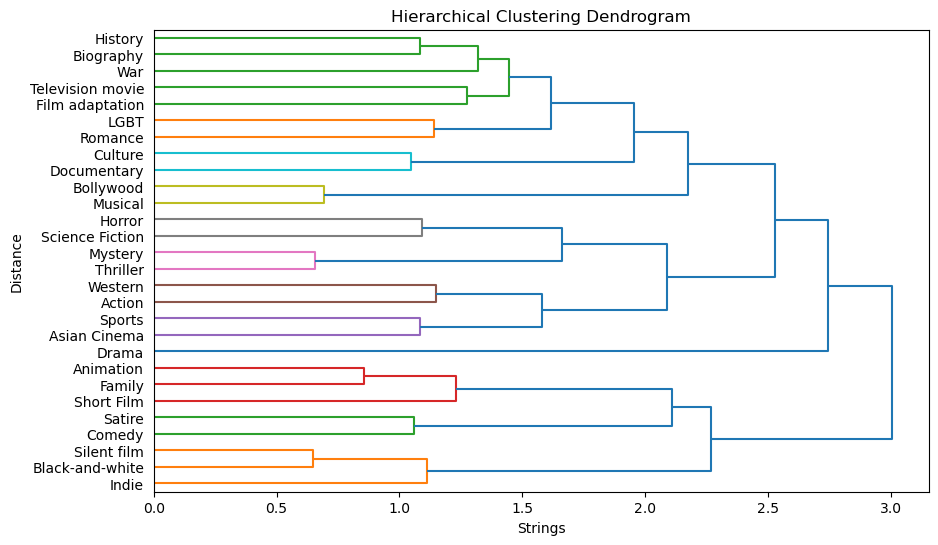

In [22]:
# Plot the dendrogram to visualize hierarchical clustering
plt.figure(figsize=(10, 6))
dendrogram(
    linkage_matrix,
    labels=co_occurrence_matrix.index,
    orientation="right",
    color_threshold=1.5,
)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Strings")
plt.ylabel("Distance")
plt.show()

In [23]:
clusters = fcluster(linkage_matrix, t=1.5, criterion="distance")

In [24]:
# Create a dict to map cluster labels to total_occurences indices
cluster_dict = defaultdict(list)

for i, cluster_number in enumerate(clusters):
    cluster_dict[cluster_number].append(total_occurences.index[i])

cluster_dict = dict(cluster_dict)

print(cluster_dict)

{12: ['Drama'], 2: ['Comedy', 'Satire'], 6: ['Thriller', 'Mystery'], 5: ['Action', 'Western'], 10: ['Romance', 'LGBT'], 1: ['Black-and-white', 'Indie', 'Silent film'], 3: ['Short Film', 'Family', 'Animation'], 9: ['Documentary', 'Culture'], 7: ['Science Fiction', 'Horror'], 8: ['Musical', 'Bollywood'], 4: ['Asian Cinema', 'Sports'], 11: ['Biography', 'History', 'War', 'Film adaptation', 'Television movie']}


<Axes: >

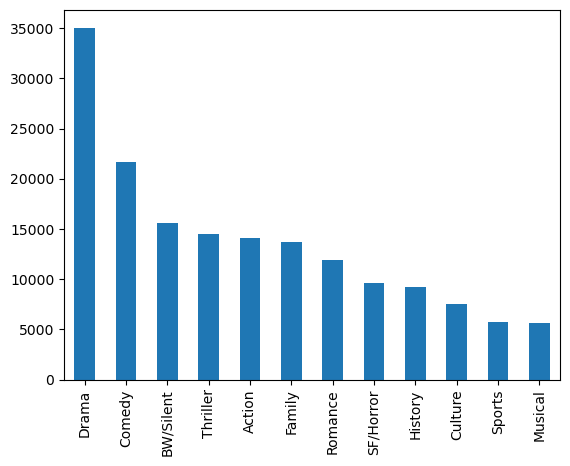

In [25]:
cluster_keys = [
    "Drama",
    "Comedy",
    "Thriller",
    "Action",
    "Romance",
    "BW/Silent",
    "Family",
    "Culture",
    "SF/Horror",
    "Musical",
    "Sports",
    "History",
]


genres_dict = dict(zip(cluster_keys, list(cluster_dict.values())))



movie["Movie_main_genres"] = (
    movie["Movie_clean_genres"].dropna().apply(lambda x: clean_genres(x, genres_dict))
)

main_genre_occ = (
    movie["Movie_main_genres"]
    .apply(lambda x: pd.Series(x).value_counts())
    .sum()
    .sort_values(ascending=False)
)



main_genre_occ.plot(kind="bar")

In [26]:
def sorted_main_genres(item):
    return list(main_genre_occ.index).index(item)


# In order to have the main genre, the second genre, etc...
movie["Movie_main_genres"] = (
    movie["Movie_main_genres"]
    .dropna()
    .apply(lambda x: sorted(x, key=sorted_main_genres))
)

## Genres through time
To visualize new genres emerging.

In [27]:
name_genre_year = []
for index, row in (
    movie[["Movie_name", "Movie_clean_genres", "Movie_release_date"]]
    .dropna()
    .iterrows()
):
    sublist = row["Movie_clean_genres"]
    for genre in sublist:
        name_genre_year.append(
            (row["Movie_name"], genre, row["Movie_release_date"].year)
        )
name_genre_year = pd.DataFrame(name_genre_year, columns=["name", "genre", "year"])
name_genre_year.head()

,name,genre,year
0,Ghosts of Mars,Thriller,2001
1,Ghosts of Mars,Science Fiction,2001
2,Ghosts of Mars,Horror,2001
3,Ghosts of Mars,Action,2001
4,Getting Away with Murder: The JonBenét Ramsey ...,Mystery,2000


<Axes: xlabel='year'>

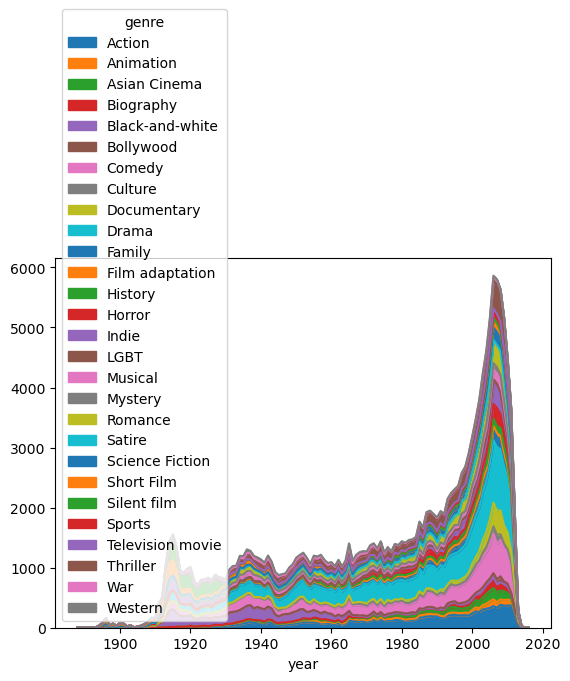

In [28]:
genre_counts = name_genre_year.groupby(["year", "genre"]).size().unstack(fill_value=0)
genre_counts.plot.area()

Text(0.5, 1.0, 'Proportion of movies of given genre along time')

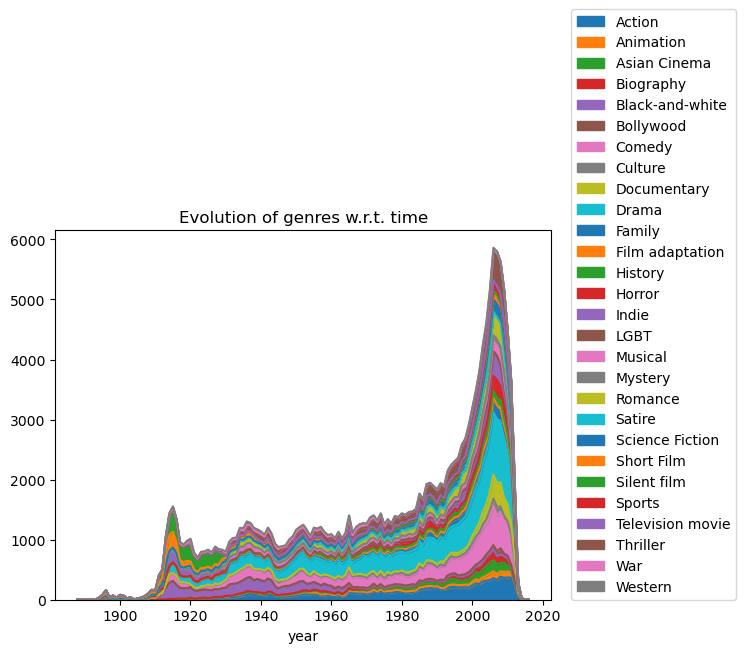

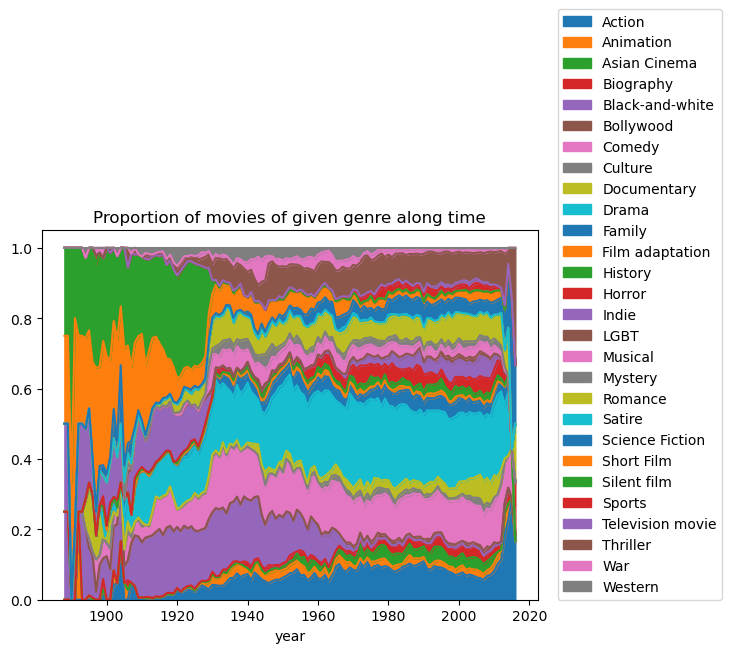

In [29]:
genre_counts = name_genre_year.groupby(["year", "genre"]).size().unstack(fill_value=0)
genre_counts.plot.area(stacked=True)
plt.legend(bbox_to_anchor=(1.04, 0), loc="lower left", borderaxespad=0)
plt.title("Evolution of genres w.r.t. time")
genre_counts = genre_counts.apply(lambda row: row / sum(row), axis=1)
genre_counts.head(10)

genre_counts.plot.area(stacked=True)
plt.legend(bbox_to_anchor=(1.04, 0), loc="lower left", borderaxespad=0)
plt.title("Proportion of movies of given genre along time")

Similarly, it would be interesting to compare the number of genres assigned to movies on average per year.

In [36]:
genre_average = name_genre_year.groupby(["year", "name"]).size().unstack(fill_value=0)
genre_average.sample(20)

ValueError: No axis named 1 for object type Series